In [2]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

df = pd.read_csv("C:/SharedFolders/metagenomics/tim_sheep/viral_association/flye4.contigs.vassoc.final.tab", sep="\t", header=0)
df.describe()

,VirusCtg,HostCtg,Category,VirusFamily,HostKingdom,HostFamily,Evidence
count,424,424,424,424,424,424,424
unique,174,337,3,9,5,52,110
top,contig_48319,contig_76462,Read,Siphoviridae,Bacteria,Methanobacteriaceae,Read:3
freq,43,5,356,227,248,89,69


OK, data is loaded. Let's remove the cases where the HostKingdom is also "Viruses" so we can generate a bipartite plot.

In [4]:
df = df[df['HostKingdom'] != 'Viruses']
df.describe()

,VirusCtg,HostCtg,Category,VirusFamily,HostKingdom,HostFamily,Evidence
count,382,382,382,382,382,382,382
unique,157,303,3,9,4,46,89
top,contig_48319,contig_76462,Read,Siphoviridae,Bacteria,Methanobacteriaceae,Read:3
freq,43,5,356,196,248,89,69


## More data filtering

I may have removed some legitimate viral contig associations, or some degenerate prophage that serve as targets for viral integration. This is a known biological mechanism for integration; however, I can't make a bipartite plot without the removal of these contigs! My goal is to create the bipartite plot sorted by viral class to test any associations of viral detection strategy with their putative lifecycles.

In [5]:
df.head()

,VirusCtg,HostCtg,Category,VirusFamily,HostKingdom,HostFamily,Evidence
0,contig_11399,contig_1378,Read,Siphoviridae,Bacteria,Firmicutes,Read:129
1,contig_11399,contig_1421,HiC,Siphoviridae,Bacteria,Clostridiaceae,HiC:655
2,contig_11399,contig_19305,Read,Siphoviridae,Bacteria,Firmicutes,Read:3
3,contig_11399,contig_25201,Read,Siphoviridae,Bacteria,Lachnospiraceae,Read:25
4,contig_11399,contig_3177,Read,Siphoviridae,Bacteria,Firmicutes,Read:22


In [6]:
df = df.sort_values(by=['VirusFamily','VirusCtg','Category'])
df.head()

,VirusCtg,HostCtg,Category,VirusFamily,HostKingdom,HostFamily,Evidence
134,contig_29900,contig_29897,Read,Ackermannviridae,no-hit,no-hit,Read:15
135,contig_29900,contig_43786,Read,Ackermannviridae,Bacteria,Clostridiaceae,Read:5
91,contig_22364,contig_55899,Read,Herelleviridae,Bacteria,Akkermansiaceae,Read:3
92,contig_22366,contig_15499,Read,Herelleviridae,Bacteria,Akkermansiaceae,Read:40
393,contig_72272,contig_32694,Read,Microviridae,Bacteria,Anaerolineaceae,Read:37


## Now for the plotting!

I'm going to load the network plot using the first two columns, but then classify nodes by host kingdom/viral genera and edges by method

In [7]:
from collections import defaultdict

graph = nx.Graph()
vgenus = defaultdict(list)
hking = defaultdict(list)
ecat = defaultdict(list)

graph.add_nodes_from(df['VirusCtg'].unique())
graph.add_nodes_from(df['HostCtg'].unique())

for index, row in df.iterrows():
    vgenus[row['VirusFamily']].append(row['VirusCtg'])
    hking[row['HostKingdom']].append(row['HostCtg'])
    graph.add_edge(row['VirusCtg'], row['HostCtg'])
    ecat[row['Category']].append((row['VirusCtg'], row['HostCtg']))

Viral Family Ackermannviridae color: tab:blue
Viral Family Herelleviridae color: tab:orange
Viral Family Microviridae color: tab:green
Viral Family Mimiviridae color: tab:red
Viral Family Myoviridae color: tab:purple
Viral Family Phycodnaviridae color: tab:brown
Viral Family Podoviridae color: tab:pink
Viral Family Siphoviridae color: tab:gray
Viral Family Viruses color: tab:olive
Host kingdom no-hit color: b
Host kingdom Bacteria color: g
Host kingdom Eukaryota color: r
Host kingdom Archaea color: k


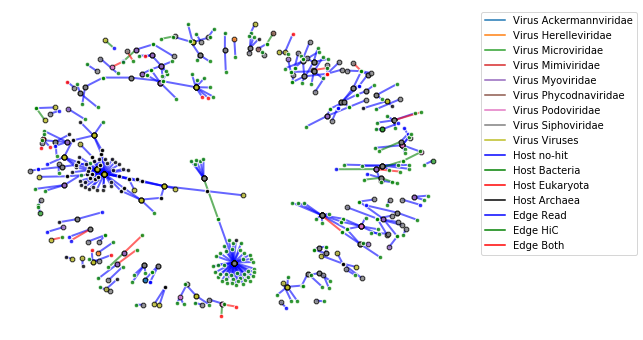

In [11]:
pos = nx.spring_layout(graph, k=0.11)
#pos = nx.shell_layout(graph, [df['HostCtg'].unique(), df['VirusCtg'].unique()])

#vcolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
vcolors = [name for name, color in matplotlib.colors.TABLEAU_COLORS.items()]
hcolors = ['b', 'g', 'r', 'k']
ecolors = {"Read" : 'b', "HiC" : 'g', "Both" : 'r'}

f = plt.figure(figsize=(8,6))
ax = f.add_subplot(1,1,1)

labels = dict()

for i in range(len(vgenus.keys())):
    k = list(vgenus.keys())[i]
    if i >= len(vcolors):
        i = len(vcolors) - 1
    print(f'Viral Family {k} color: {vcolors[i]}')
    labels['Virus ' + k] = vcolors[i]
    nx.draw_networkx_nodes(graph, pos, nodelist=vgenus[k], node_color=vcolors[i], edgecolors='k', alpha=0.8, node_size=25, node_shape='8')
    
for i in range(len(hking.keys())):
    k = list(hking.keys())[i]
    if i >= 4:
        i = 3
    print(f'Host kingdom {k} color: {hcolors[i]}')
    labels['Host ' + k] = hcolors[i]
    nx.draw_networkx_nodes(graph, pos, nodelist=hking[k], node_color=hcolors[i], edgecolors='w', alpha=0.8, node_size=20, node_shape='o')
    
for k, v in ecolors.items():
    labels['Edge ' + k] = ecolors[k]
    nx.draw_networkx_edges(graph, pos, edgelist=ecat[k], width=2, alpha=0.6, edge_color=ecolors[k])
    
for k, v in labels.items():
    ax.plot([0], [0], color = v, label=k)
    
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)
plt.savefig("C:/SharedFolders/metagenomics/tim_sheep/viral_association/hifi_flye4_networkplot.pdf")